In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Bias-Variance Tradeoff with the model complexity


*   Variance: The variability of a model's prediction for a given data point.

*   Bias: The difference between a model's expected (or average) predictions and the true values which we are trying to predict.

*   Noise: The measure of ambiguity due to the data distribution and feature representation. You can never beat this, it is an aspect of the data.

Fundamentally, addressing bias and variance is essentially about navigating the challenges of overfitting and underfitting. As the complexity of a model increases with the addition of more parameters, bias decreases while variance increases. This means that with each additional parameter, such as extra polynomial terms in a linear regression, the model becomes more complex. Consequently, variance begins to dominate our concerns as bias gradually diminishes. Put another way, bias decreases as model complexity grows, showing a negative first-order derivative relationship, whereas variance increases, indicating a positive relationship with model complexity.

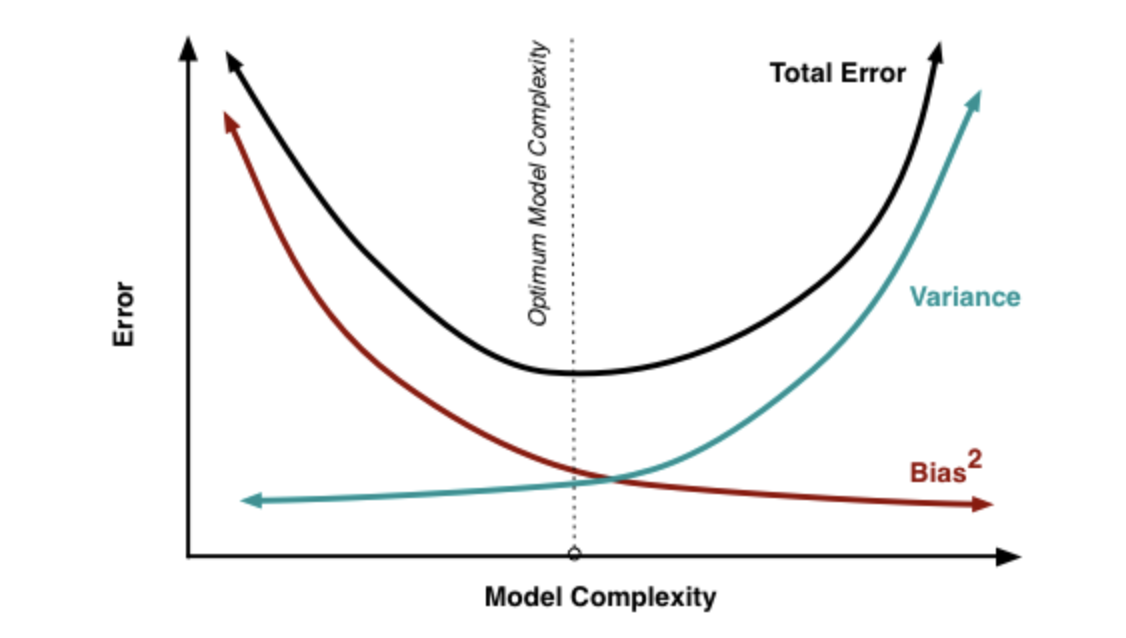

In [2]:
# Load the image file
image_path = 'Tradeoff.png'
with open(image_path, 'rb') as f:
  image_bytes = f.read()

from IPython.display import Image
Image(image_bytes)


*Source: http://scott.fortmann-roe.com/docs/BiasVariance.html*

# Weak random features

Here we'll generate data using the so-called weak random features model:

1. the first `num_informative_features` features are noisy versions of the label `y`
2. the rest of the features are pure noise

We're interested in understanding the optimal model complexity as a function of the number of features we choose, in each of these models.

## Questions

1. How does the optimal model complexity depend on the noise in the features?
2. When does the error curve exhibit a "double descent" behavior? When is the best model found on the first descent vs the second descent?
3. How does this phenomenon depend on the choice of optimizer / regularizer, for underconstrained problems?

In [3]:
def random_features(n=100, d=100, num_informative_features=20):
    y = np.random.randn(n)
    X = np.random.randn(n, min(d, num_informative_features)) + y.reshape(-1, 1)
    if d > num_informative_features:
        X = np.hstack((X, np.random.randn(n, d - num_informative_features)))
    return X, y

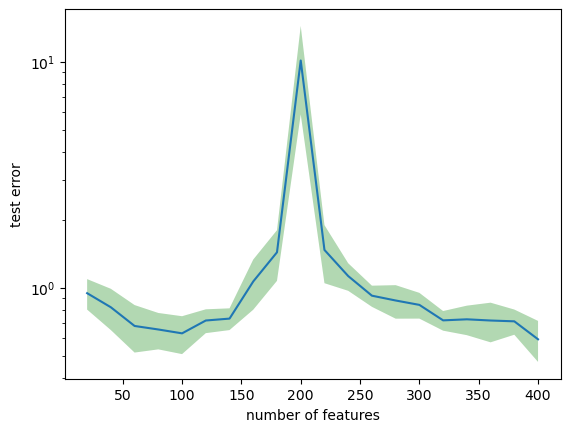

In [4]:
n = 200
ds = np.arange(20, 2 * n + 1, 20)
num_informative_features = 100
nreps = 10

mses = np.zeros((len(ds), nreps))
train_errors = np.zeros((len(ds), nreps))

for rep in range(1, nreps + 1):
    mse = []
    train_error = []
    for d in ds:
        Xtrain, ytrain = random_features(n, d, num_informative_features=num_informative_features)
        w = np.linalg.lstsq(Xtrain, ytrain, rcond=None)[0]
        Xtest, ytest = random_features(int(n / 10), d, num_informative_features=num_informative_features)
        mse.append(np.linalg.norm(ytest - Xtest.dot(w)))
        train_error.append(np.linalg.norm(ytrain - Xtrain.dot(w)))
    mses[:, rep - 1] = mse
    train_errors[:, rep - 1] = train_error

mean_mse = np.mean(mses, axis=1)
std_mse = np.std(mses, axis=1)
mean_te = np.mean(train_errors, axis=1)
std_te = np.std(train_errors, axis=1)

std_mse = np.minimum(std_mse, 0.9 * mean_mse)
std_te = np.minimum(std_te, 0.9 * mean_te)

plt.plot(ds, mean_mse, label="Test MSE")
plt.fill_between(ds, mean_mse - std_mse, mean_mse + std_mse, facecolor='g', alpha=0.3)
plt.yscale('log')
plt.ylabel('test error')
plt.xlabel('number of features')
plt.show()

## Observations:

1. The error blows up as $d \to n$.
2. With 10 informative features, the best test error occurs for d as small as possible.
3. With 100 informative features, the best test error occurs around d=100.
4. When all features are informative, the best test error occurs as $d \to \infty$ (or, at least, as large as we tested).

# One Standard Error Rule

The One Standard Error Rule is a method for choosing the most **streamlined** model that still maintains a low error rate by comparing models with varying numbers of parameters.

The approach involves identifying the model that has the lowest error and then choosing the least complex model whose mean error is no more than one standard deviation away from this minimum error.


In [5]:
df = pd.read_csv('winequality-red.csv', sep=';')

y = df['quality']
X = df.drop('quality', axis=1)

In [10]:
candidate_alpha = [10**i for i in np.linspace(-5, -2, 10)]  # can change 10 to other values
candidate_regressors = [Lasso(alpha=a, fit_intercept=False) for a in candidate_alpha]

In [11]:
import warnings
warnings.filterwarnings("ignore")

cv_results = [-cross_val_score(r, X, y, scoring='neg_root_mean_squared_error', cv=10) for r in candidate_regressors]
cv_means = np.array([np.mean(cv) for cv in cv_results])
cv_se = np.array([np.std(cv) / np.sqrt(10) for cv in cv_results])

In [12]:
min_i = np.argmin(cv_means)
cutoff = cv_means[min_i] + cv_se[min_i]

one_se_rule_i = np.argmax(candidate_alpha * (cv_means < cutoff))

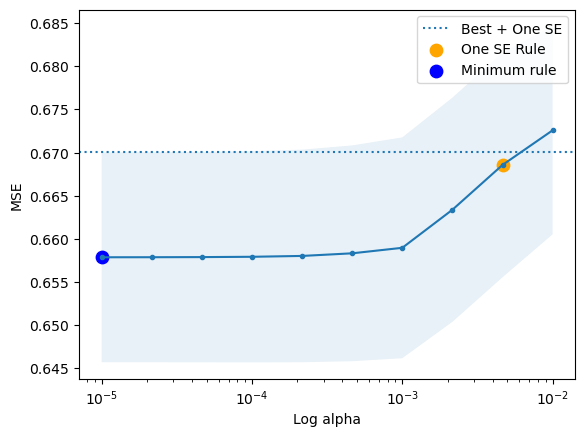

In [30]:
plt.plot(candidate_alpha, cv_means,'.-')
plt.fill_between(candidate_alpha, cv_means + 1*cv_se, cv_means - 1*cv_se, alpha=.1)
plt.axhline(cutoff, linestyle='dotted', label='Best + One SE')
plt.scatter([candidate_alpha[one_se_rule_i]], [cv_means[one_se_rule_i]], marker='o', s=80, color='orange', label='One SE Rule')
plt.scatter([candidate_alpha[min_i]], [cv_means[min_i]], marker='o', s=80, color='blue', label='Minimum rule')
plt.legend()
plt.xscale('log')
plt.xlabel('Log alpha')
plt.ylabel('MSE')
plt.show()